In [2]:
'''
  code by Tae Hwan Jung(Jeff Jung) @graykode, modify by wmathor
'''
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

dtype = torch.FloatTensor

sentences = [ "i like dog", "i love coffee", "i hate milk"]

word_list = " ".join(sentences).split()
vocab = list(set(word_list))
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}
n_class = len(vocab)

# TextRNN Parameter
batch_size = 2
n_step = 2 # number of cells(= number of Step)
n_hidden = 5 # number of hidden units in one cell

def make_data(sentences):
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split()
        input = [word2idx[n] for n in word[:-1]]
        target = word2idx[word[-1]]

        input_batch.append(np.eye(n_class)[input])
        target_batch.append(target)

    return input_batch, target_batch

input_batch, target_batch = make_data(sentences)
input_batch, target_batch = torch.Tensor(input_batch), torch.LongTensor(target_batch)
dataset = Data.TensorDataset(input_batch, target_batch)
loader = Data.DataLoader(dataset, batch_size, True)

class TextRNN(nn.Module):
    def __init__(self):
        super(TextRNN, self).__init__()
        self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden)
        # fc
        self.fc = nn.Linear(n_hidden, n_class)

    def forward(self, hidden, X):
        # X: [batch_size, n_step, n_class]
        X = X.transpose(0, 1) # X : [n_step, batch_size, n_class]
        out, hidden = self.rnn(X, hidden)
        # out : [n_step, batch_size, num_directions(=1) * n_hidden]
        # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        out = out[-1] # [batch_size, num_directions(=1) * n_hidden] ⭐
        model = self.fc(out)
        return model

model = TextRNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(5000):
    for x, y in loader:
      # hidden : [num_layers * num_directions, batch, hidden_size]
      hidden = torch.zeros(1, x.shape[0], n_hidden)
      # x : [batch_size, n_step, n_class]
      pred = model(hidden, x)

      # pred : [batch_size, n_class], y : [batch_size] (LongTensor, not one-hot)
      loss = criterion(pred, y)
      if (epoch + 1) % 1000 == 0:
          print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  
input = [sen.split()[:2] for sen in sentences]
# Predict
hidden = torch.zeros(1, len(input), n_hidden)
predict = model(hidden, input_batch).data.max(1, keepdim=True)[1]
print([sen.split()[:2] for sen in sentences], '->', [idx2word[n.item()] for n in predict.squeeze()])

Epoch: 1000 cost = 0.095877
Epoch: 1000 cost = 0.085281
Epoch: 2000 cost = 0.015408
Epoch: 2000 cost = 0.012758
Epoch: 3000 cost = 0.004228
Epoch: 3000 cost = 0.004323
Epoch: 4000 cost = 0.001441
Epoch: 4000 cost = 0.001490
Epoch: 5000 cost = 0.000521
Epoch: 5000 cost = 0.000535
[['i', 'like'], ['i', 'love'], ['i', 'hate']] -> ['dog', 'coffee', 'milk']


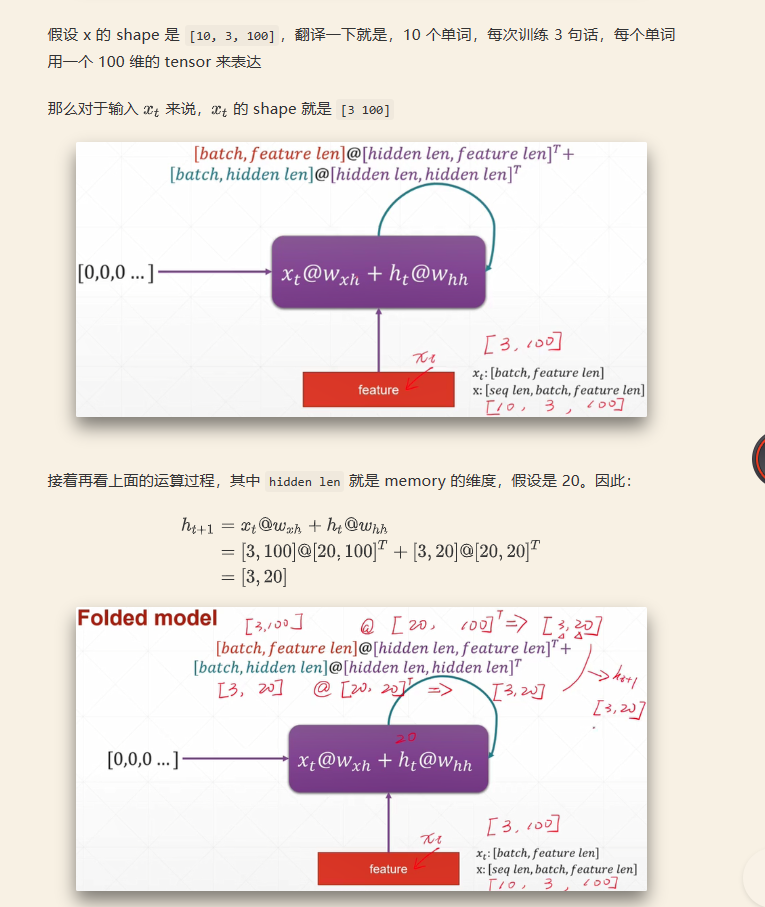

In [10]:
import torch
import torch.nn as nn

rnn = nn.RNN(100, 20)
print(rnn._parameters.keys())
print(rnn.weight_ih_l0.shape) # w_{xh} [20, 100]
print(rnn.weight_hh_l0.shape) # w_{hh} [20, 20]
print(rnn.bias_ih_l0.shape) # b_{xh} [20]
print(rnn.bias_hh_l0.shape) # b_{hh} [20]

odict_keys(['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0'])
torch.Size([20, 100])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20])


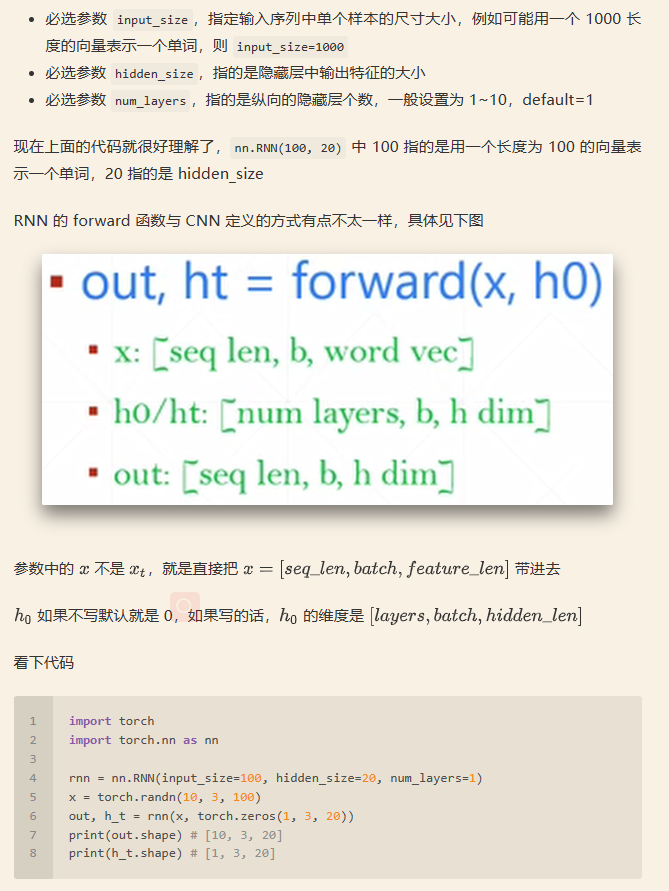

In [11]:
import torch
import torch.nn as nn

rnn = nn.RNN(input_size=100, hidden_size=20, num_layers=1)
"""
这里的x不是x_t
假设x的shape是[10, 3, 100]，翻译一下就是，
10个单词，每次训练3句话，每个单词用一个100维的 tensor 来表达
那么对于输入 x_t 来说， x_t 的shape 就是 [3 100]

其中 hidden_len 就是 memory 的维度

x_t  = [batch,feature_len]
w_xh = [hidden_len, feature_len]
h_t  = [batch, hidden_len]
w_hh = [hidden_len, hidden_len]

RNN操作：
h_(t+1)= x_t*w_xh^T+h_t*w_hh
维数：
(3 X 100)X(20 X 100)^T + (3 X 20)X( 20 X 20)^T = (3 X 20) + (3 X 20) 
"""
x = torch.randn(10, 3, 100)
out, h_t = rnn(x, torch.zeros(1, 3, 20))
print(out.shape) # [10, 3, 20]
print(h_t.shape) # [1, 3, 20]

torch.Size([10, 3, 20])
torch.Size([1, 3, 20])


In [13]:
import torch
import torch.nn as nn

rnn = nn.RNN(input_size=100, hidden_size=20, num_layers=4)
x = torch.randn(10, 3, 100)
out, h_t = rnn(x)
"""
h_t 是最后一个时间点上面的 memory状态
out 所有时间点上的最后一个 memory状态
"""
print(out.shape) # [10, 3, 20]
print(h_t.shape) # [4, 3, 20]

torch.Size([10, 3, 20])
torch.Size([4, 3, 20])


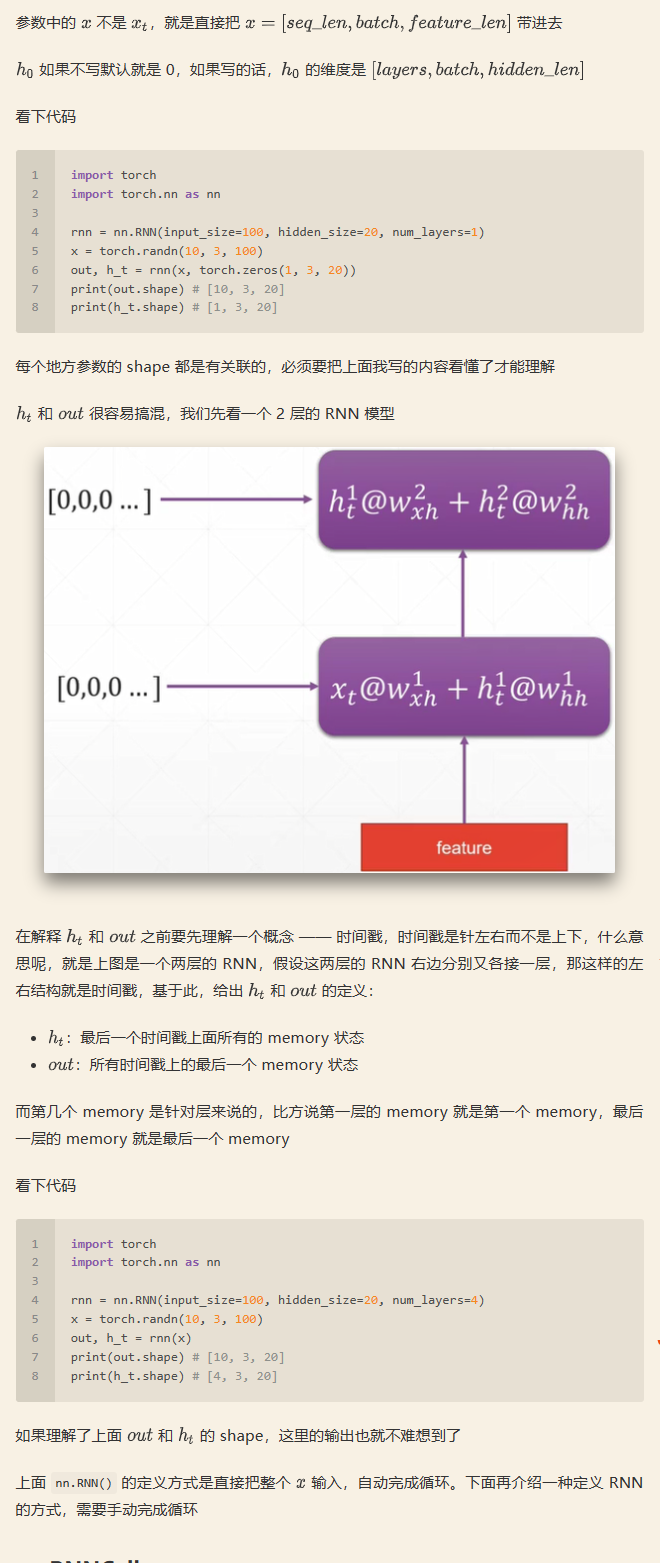

In [14]:
'''
  code by Tae Hwan Jung(Jeff Jung) @graykode, modify by wmathor
'''
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

dtype = torch.FloatTensor

In [15]:
"""
准备数据
"""
sentences = [ "i like dog", "i love coffee", "i hate milk"]

word_list = " ".join(sentences).split()
vocab = list(set(word_list))
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}
n_class = len(vocab) # 相对于分 7 类

In [16]:
word_list 

['i', 'like', 'dog', 'i', 'love', 'coffee', 'i', 'hate', 'milk']

In [17]:
vocab 

['hate', 'milk', 'love', 'dog', 'coffee', 'i', 'like']

In [18]:
"""
由词得到编码
"""
word2idx

{'hate': 0, 'milk': 1, 'love': 2, 'dog': 3, 'coffee': 4, 'i': 5, 'like': 6}

In [19]:
"""
由编码得到词
"""
idx2word

{0: 'hate', 1: 'milk', 2: 'love', 3: 'dog', 4: 'coffee', 5: 'i', 6: 'like'}

In [23]:
"""
预处理数据，构建Dataset，定义DataLoader，输入数据用one-hot编码
"""
# TextRNN Parameter
"""
batch_size = 2  表示 每次训练2句话
n_step = 2  表示 每句话有三个单词，取前两个单词作为输入 或者 2个细胞
n_hidden = 5  表示 相当于用 word2vec, 比如之前用50维编码表示，通过这个得到用5维数据表示即可
"""
batch_size = 2 # 表示 每次训练2句话
n_step = 2 # number of cells(= number of Step)
n_hidden = 5 # number of hidden units in one cell

def make_data(sentences):
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split() # list，空格进行切分
        """
        word[:-1] 取除了最后一个词的所有词
        [word2idx[n] 表示获取每一个词的索引，为list
        
        word[-1] 表示最后一个词
        word2idx[word[-1]] 表示最后一个词所对应的索引
        
        np.eye(n_class) 构建出 n_class X n_class 维的单位对角矩阵
        n_class = len(vocab) # 相对于分 7 类
        """
        input = [word2idx[n] for n in word[:-1]]
        target = word2idx[word[-1]] #

        input_batch.append(np.eye(n_class)[input])
        target_batch.append(target)

    return input_batch, target_batch

input_batch, target_batch = make_data(sentences)
input_batch, target_batch = torch.Tensor(input_batch), torch.LongTensor(target_batch)
dataset = Data.TensorDataset(input_batch, target_batch)
loader = Data.DataLoader(dataset, batch_size, True)

In [28]:
"""
相当于 One-hot编码
np.eye(7)构建7X7的单位矩阵
[[1,2,5]]挑选出1,2,5行对应的数据
"""
print(np.eye(7)[[1,2,5]])

[[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


In [22]:
target_batch

tensor([3, 4, 1])

In [29]:
"""
接下来就是定义网络架构
"""
class TextRNN(nn.Module):
    def __init__(self):
        super(TextRNN, self).__init__()
        """
        input_size=n_class
        表示每个词的编码维度，由于我是用的one-hot编码，而不是WordEmbedding，
        所以input_size就等于词库的大小len(vocab)，即n_class
        
        然后是hidden_size，这个参数没有固定的要求，
        你想将输入数据的维度转为多少维，就设定多少
        就是之前用50维，现在就可以改为4维向量表示
        """
        self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden)
        # fc
        self.fc = nn.Linear(n_hidden, n_class)

    def forward(self, hidden, X):
        """
        对于通常的神经网络来说，输入数据的第一个维度一般都是batch_size。
        而PyTorch中nn.RNN()要求将batch_size放在第二个维度上，
        所以需要使用x.transpose(0, 1)将输入数据的第一个维度和第二个维度互换
        
        然后是rnn的输出，rnn会返回两个结果，即上面代码的out和hidden，
        n_class表示用多少维去编码，其实就是多少个0和1
        
        n_step = 2  表示 每句话有三个单词，取前两个单词作为输入 或者 2个细胞
        
        batch_size 表示 一次性处理多少个句子
        
        然后是hidden_size，这个参数没有固定的要求，
        你想将输入数据的维度转为多少维，就设定多少
        
       
        h_t 是最后一个时间点上面的 memory状态, 其实就是 X_3,H_3,Y_3
        out 所有时间点上的最后一个 memory状态，其实就是 Y_0,Y_1,Y_2,Y_3
        
        out = out[-1] 表示取out里面最后一个向量，其实就是Y_3
        """
        # X: [batch_size, n_step, n_class]
        X = X.transpose(0, 1) # X : [n_step, batch_size, n_class]
        out, hidden = self.rnn(X, hidden)
        # out : [n_step, batch_size, num_directions(=1) * n_hidden]
        # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        out = out[-1] # [batch_size, num_directions(=1) * n_hidden] ⭐
        model = self.fc(out)
        return model

model = TextRNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

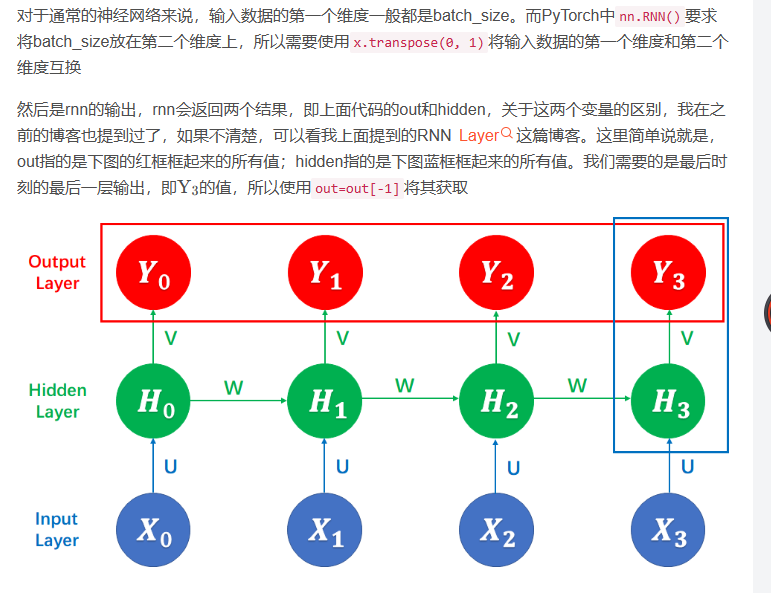

In [30]:
import torch
import torch.nn as nn

rnn = nn.RNN(input_size=100, hidden_size=20, num_layers=1)
"""
这里的x不是x_t
假设x的shape是[10, 3, 100]，翻译一下就是，
10个单词，每次训练3句话，每个单词用一个100维的 tensor 来表达
那么对于输入 x_t 来说， x_t 的shape 就是 [3 100]

其中 hidden_len 就是 memory 的维度

x_t  = [batch,feature_len]
w_xh = [hidden_len, feature_len]
h_t  = [batch, hidden_len]
w_hh = [hidden_len, hidden_len]

RNN操作：
h_(t+1)= x_t*w_xh^T+h_t*w_hh
维数：
(3 X 100)X(20 X 100)^T + (3 X 20)X( 20 X 20)^T = (3 X 20) + (3 X 20) 
"""
x = torch.randn(10, 3, 100)
out, h_t = rnn(x, torch.zeros(1, 3, 20))
print(out.shape) # [10, 3, 20]
print(h_t.shape) # [1, 3, 20]

torch.Size([10, 3, 20])
torch.Size([1, 3, 20])


In [31]:
for x, y in loader:
    print(x)

tensor([[[0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0.]]])
tensor([[[0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0.]]])


In [32]:
x.shape[0]

1

In [37]:
# Training
for epoch in range(5000):
    for x, y in loader:
      # hidden : [num_layers * num_directions, batch, hidden_size]
      """
      hidden表示h_0
      num_layers 表示行数，其实就是多少个RNN
      num_directions 表示列数，双向RNN中用
      
      batch_size=x.shape[0]=1 每次处理
      
      n_hidden 表示输出用多少维编码表示
      """
      hidden = torch.zeros(num_layers=1, batch_size=x.shape[0], n_hidden)
      # x : [batch_size, n_step, n_class]
      pred = model(hidden, x)

      # pred : [batch_size, n_class], y : [batch_size] (LongTensor, not one-hot)
      loss = criterion(pred, y)
      if (epoch + 1) % 1000 == 0:
          print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

"""
input:
[['i', 'like'], ['i', 'love'], ['i', 'hate']]
每次取每个句子里面的前两个单词

hidden 的维数：[num_layers * num_directions, batch, hidden_size]
hidden = torch.zeros(1, len(input), n_hidden)
每次用一个卷积，每次处理3个单词
"""
input = [sen.split()[:2] for sen in sentences]
# Predict
hidden = torch.zeros(1, len(input), n_hidden) # 就是h_0
predict = model(hidden, input_batch).data.max(1, keepdim=True)[1]
print([sen.split()[:2] for sen in sentences], '->', [idx2word[n.item()] for n in predict.squeeze()])

SyntaxError: positional argument follows keyword argument (<ipython-input-37-fd0b60d62aa5>, line 14)

In [35]:
input = [sen.split()[:2] for sen in sentences]
input

[['i', 'like'], ['i', 'love'], ['i', 'hate']]

In [36]:
len(input)

3